In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import mat73

data_dict = mat73.loadmat('Part_1.mat')

for i in range(2, 5):
    file_name = f'Part_{i}.mat'
    data = mat73.loadmat(file_name)
    data_dict['Part_1'].extend(data[f'Part_{i}'])

In [ ]:
num_matrices = len(data_dict['Part_1'])
print(num_matrices)

12000


...

## Full dataset loading and complete training loop removed.
## Please fill out the request form to access the full code.

In [ ]:
# Create empty lists to store the separate signals
ppg_list = []
abp_list = []
ecg_list = []

# Loop through each matrix in the data
for matrix in new_variable:
    # Extract the signals from the matrix
    ppg_signal = matrix[0]
    abp_signal = matrix[1]
    ecg_signal = matrix[2]

    # Append each signal to its respective list
    ppg_list.append(ppg_signal)
    abp_list.append(abp_signal)
    ecg_list.append(ecg_signal)

In [ ]:
num_matrices = len(ppg_list)
print(num_matrices)

12000


...

In [ ]:
len(abp1[0][0])

1024

In [ ]:
abp1[0][0]

tensor([67.0630, 69.3586, 75.3665,  ..., 74.5361, 73.9011, 73.3150],
       device='cuda:0', dtype=torch.float64)

In [ ]:
all_abp = torch.cat(abp1, dim=0)

In [ ]:
all_abp.shape

torch.Size([539719, 1024])

In [ ]:
all_ppg = torch.cat(ppg1, dim=0)

In [ ]:
all_ppg.shape

torch.Size([539719, 1024])

In [ ]:
all_abp[0]

tensor([67.0630, 69.3586, 75.3665,  ..., 74.5361, 73.9011, 73.3150],
       device='cuda:0', dtype=torch.float64)

In [ ]:
import numpy as np
import scipy.signal as signal  # This should be the only 'signal' reference in your script

# Assuming `all_ppg` and `all_abp` contain lists of numpy arrays
complete_ppg_signals = []
average_diastolics = []
average_systolics = []

for ppg_segment, abp_segment in zip(all_ppg, all_abp):
    avg_systolic = average_systolic_pressure(abp_segment)
    diastolic_valleys = average_diastolic_pressure(abp_segment)
    abp_segment = abp_segment.cpu().numpy()
    avg_diastolic = np.mean(abp_segment[diastolic_valleys])
    if avg_systolic is not None and avg_diastolic is not None:
        complete_ppg_signals.append(ppg_segment)
        average_systolics.append(avg_systolic)
        average_diastolics.append(avg_diastolic)

print("Number of complete PPG signals stored:", len(complete_ppg_signals))
print("Length of average systolic pressures:", len(average_systolics))
print("Length of average diastolic pressures:", len(average_diastolics))

Number of complete PPG signals stored: 539715
Length of average systolic pressures: 539715
Length of average diastolic pressures: 539715


## Full dataset loading and complete training loop removed.
## Please fill out the request form to access the full code.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold, train_test_split
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

...

# Preparing the data
x = torch.stack(complete_ppg_signals).float().unsqueeze(1)  # Add channel dimension
y = torch.tensor(average_systolics).float()

# Create a dataset
dataset = TensorDataset(x, y)

# Define the k-fold cross validator
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Array to store the fold results
results = []

# Arrays to store true values and predictions for Bland-Altman plots
all_true_values = []
all_predictions = []

# Arrays to store the loss and MAE for each fold
all_train_losses = []
all_val_losses = []
all_train_maes = []
all_val_maes = []

# Training the model
num_epochs = 500
patience = 30

test_maes = []

for fold, (train_val_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Split train_val into train and validation
    train_val_subsampler = Subset(dataset, train_val_ids)
    test_subsampler = Subset(dataset, test_ids)

    train_ids, val_ids = train_test_split(train_val_ids, test_size=0.1, random_state=42)
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)

    # Define data loaders for training, validation, and test
    train_loader = DataLoader(train_subsampler, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_subsampler, batch_size=64, shuffle=False)

    # Initialize the model, loss function, optimizer, and learning rate scheduler
    model = CNN_LSTM_Model().to(device)
    criterion = nn.MSELoss().to(device)
    mae_criterion = nn.L1Loss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

    best_loss = float('inf')
    patience_counter = 0

    fold_train_losses = []
    fold_val_losses = []
    fold_train_maes = []
    fold_val_maes = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            mae_loss = mae_criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_mae += mae_loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                mae_loss = mae_criterion(outputs, targets.view(-1, 1))
                val_loss += loss.item() * inputs.size(0)
                val_mae += mae_loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_maes.append(train_mae)
        fold_val_maes.append(val_mae)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, f'best_model_fold_{fold}.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    # Store the losses and MAEs for the fold
    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)
    all_train_maes.append(fold_train_maes)
    all_val_maes.append(fold_val_maes)

    # Evaluate the model on the test set
    checkpoint = torch.load(f'best_model_fold_{fold}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()
    test_loss = 0.0
    test_mae = 0.0
    true_values = []
    predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            mae_loss = mae_criterion(outputs, targets.view(-1, 1))
            test_loss += loss.item() * inputs.size(0)
            test_mae += mae_loss.item() * inputs.size(0)
            true_values.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_mae /= len(test_loader.dataset)

    all_true_values.append(true_values)
    all_predictions.append(predictions)

    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')
    test_maes.append(test_mae)

    results.append((test_loss, test_mae))

# Print the results for all folds
print('--------------------------------')
print('K-FOLD CROSS VALIDATION RESULTS')
print('--------------------------------')
avg_test_loss = np.mean([r[0] for r in results])
avg_test_mae = np.mean([r[1] for r in results])
std_test_mae = np.std(test_maes)
print(f'Average Test Loss: {avg_test_loss:.4f}, Average Test MAE: {avg_test_mae:.4f}')
print(f'Test MAE ± STD: {avg_test_mae:.4f} ± {std_test_mae:.4f}')

Using device: cuda
FOLD 0
--------------------------------


/home/fnst/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/500, Train Loss: 920.3686, Train MAE: 22.0822, Val Loss: 493.4929, Val MAE: 18.1506
Epoch 2/500, Train Loss: 464.2380, Train MAE: 17.4660, Val Loss: 392.2944, Val MAE: 15.7294
Epoch 3/500, Train Loss: 288.2081, Train MAE: 13.1124, Val Loss: 215.2772, Val MAE: 11.0958
Epoch 4/500, Train Loss: 173.0775, Train MAE: 9.8208, Val Loss: 146.6496, Val MAE: 8.9653
Epoch 5/500, Train Loss: 122.9106, Train MAE: 8.0916, Val Loss: 115.1816, Val MAE: 7.6663
Epoch 6/500, Train Loss: 96.2665, Train MAE: 7.0360, Val Loss: 99.1920, Val MAE: 7.0393
Epoch 7/500, Train Loss: 79.9672, Train MAE: 6.3244, Val Loss: 128.2671, Val MAE: 8.0303
Epoch 8/500, Train Loss: 71.0050, Train MAE: 5.8952, Val Loss: 71.0303, Val MAE: 5.8153
Epoch 9/500, Train Loss: 64.0672, Train MAE: 5.5602, Val Loss: 98.5652, Val MAE: 6.7485
Epoch 10/500, Train Loss: 56.9399, Train MAE: 5.2219, Val Loss: 62.1873, Val MAE: 5.3298
Epoch 11/500, Train Loss: 52.6671, Train MAE: 4.9843, Val Loss: 53.0761, Val MAE: 4.8812
Epoch 12/500,

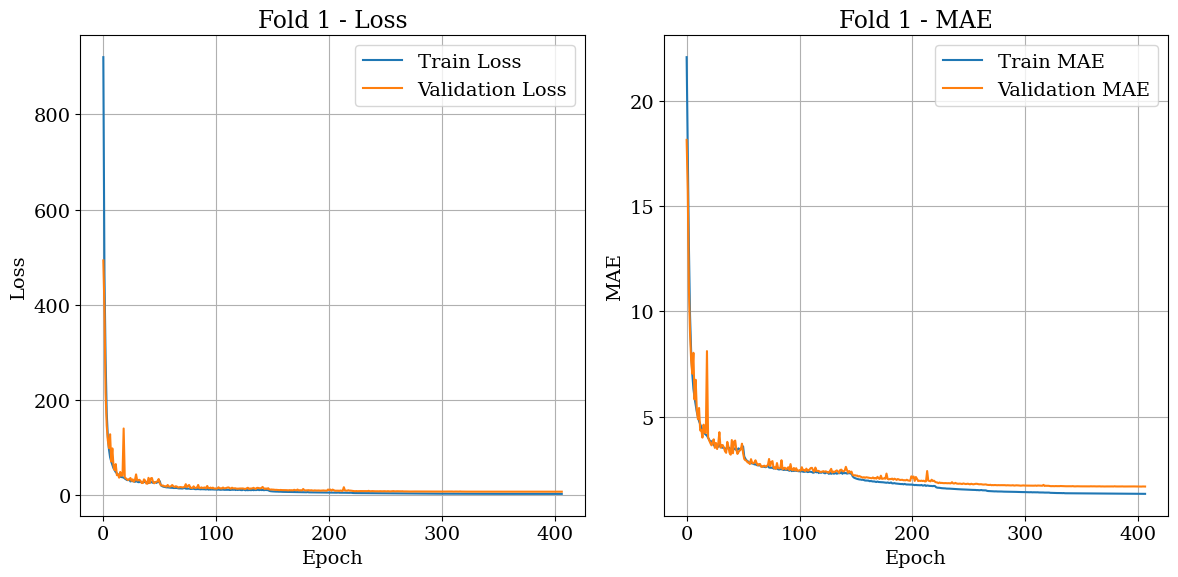

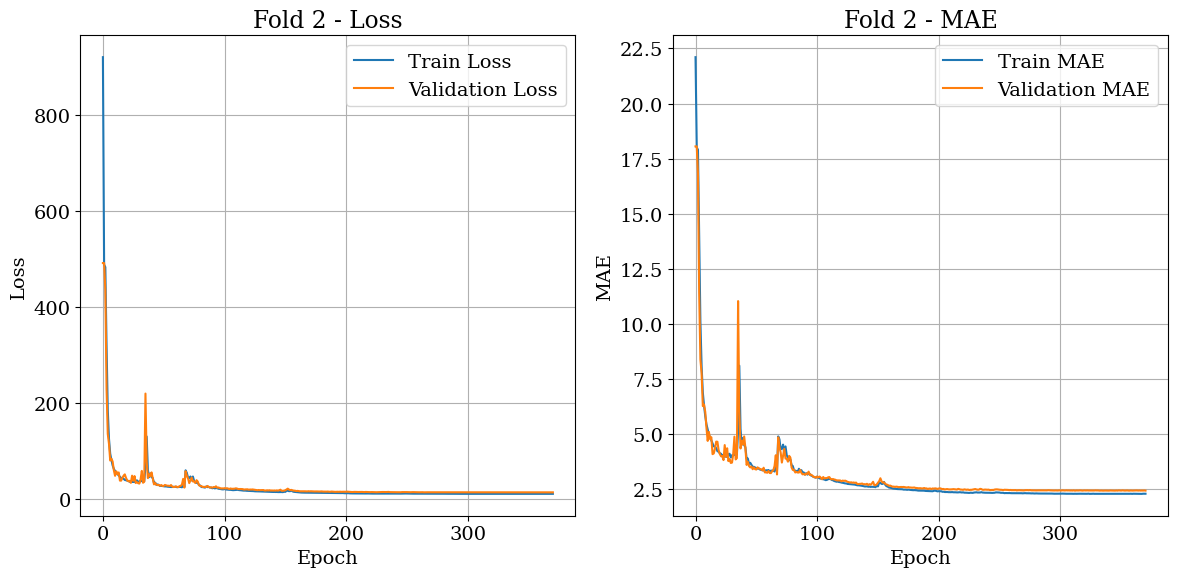

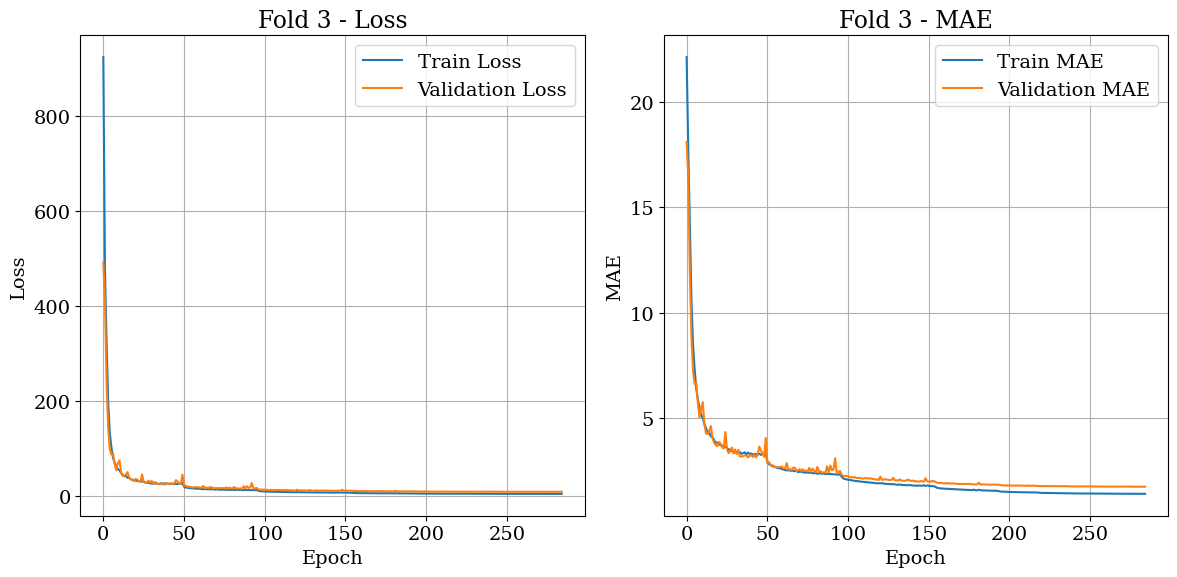

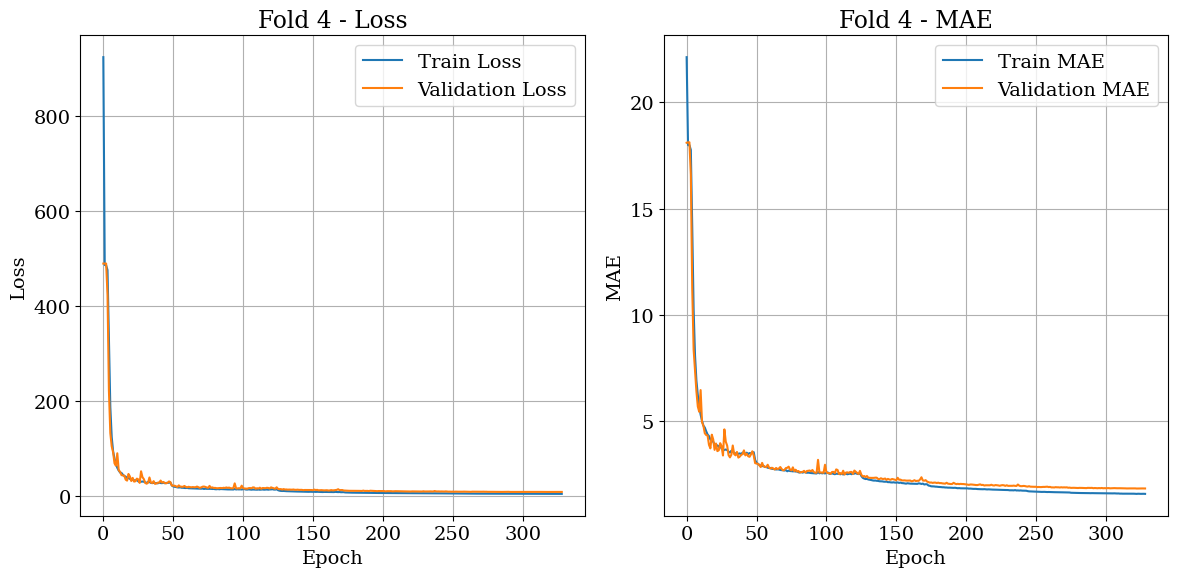

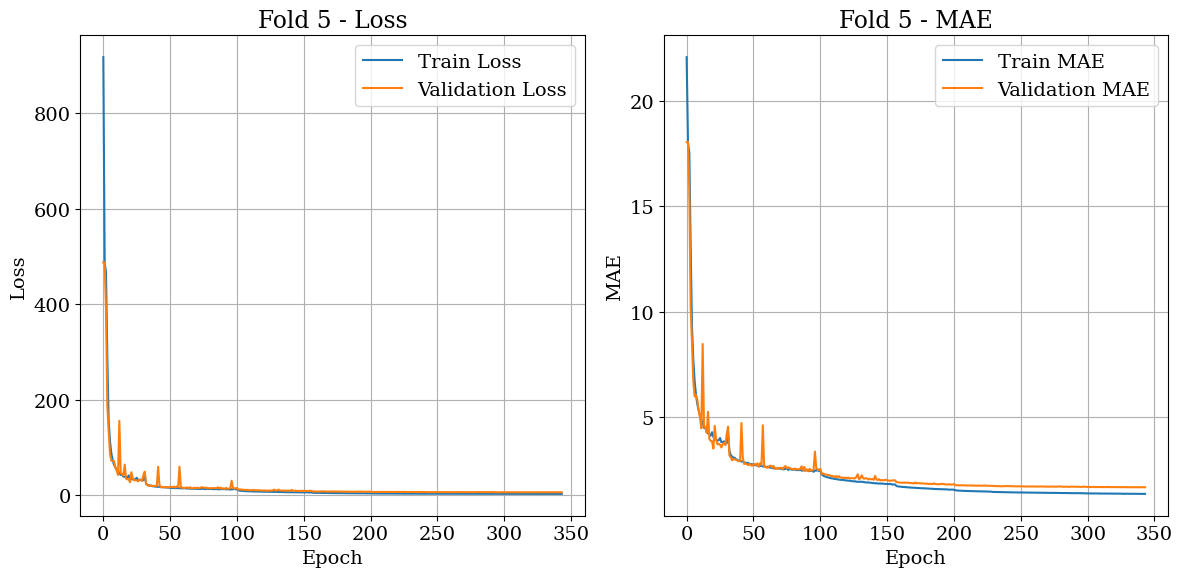

In [ ]:
def plot_loss_mae_combined(all_train_losses, all_val_losses, all_train_maes, all_val_maes):
    for i in range(len(all_train_losses)):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[i], label='Train Loss')
        plt.plot(all_val_losses[i], label='Validation Loss')
        plt.title(f'Fold {i+1} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(all_train_maes[i], label='Train MAE')
        plt.plot(all_val_maes[i], label='Validation MAE')
        plt.title(f'Fold {i+1} - MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'Fold_{i+1}_Loss_MAE.png', dpi=300)
        plt.show()

plot_loss_mae_combined(all_train_losses, all_val_losses, all_train_maes, all_val_maes)

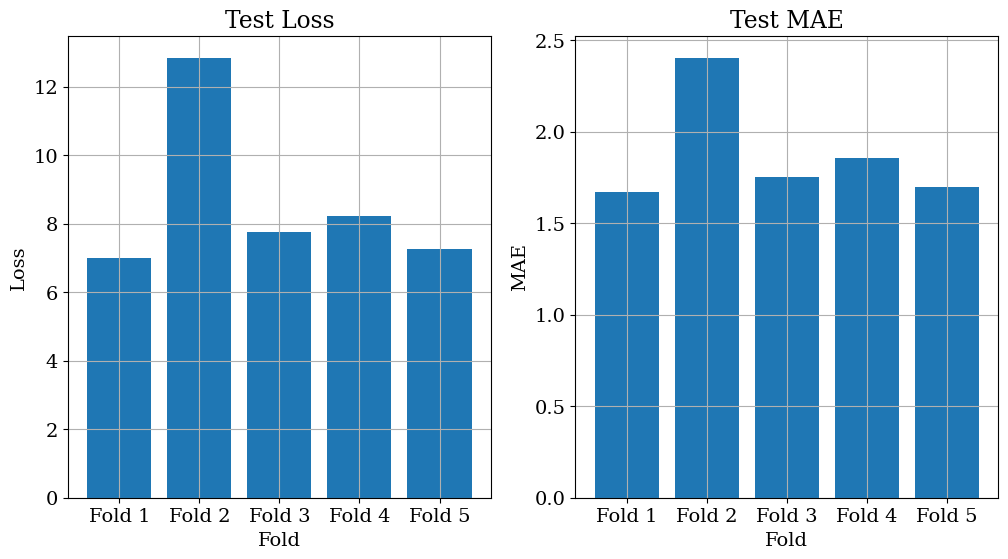

In [ ]:
import matplotlib.pyplot as plt

# Assuming the all_test_losses and all_test_maes are collected from the k-fold results
all_test_losses = [result[0] for result in results]
all_test_maes = [result[1] for result in results]

# Plot test results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(all_test_losses)), all_test_losses, tick_label=[f'Fold {i+1}' for i in range(len(all_test_losses))])
plt.title('Test Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('Test_Loss.png', dpi=300)

plt.subplot(1, 2, 2)
plt.bar(range(len(all_test_maes)), all_test_maes, tick_label=[f'Fold {i+1}' for i in range(len(all_test_maes))])
plt.title('Test MAE')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.grid(True)
plt.savefig('Test_MAE.png', dpi=300)

plt.show()

Mismatch in shapes at fold 1: true_values shape (107943,), predictions shape (107943, 1)
Mismatch in shapes at fold 2: true_values shape (107943,), predictions shape (107943, 1)
Mismatch in shapes at fold 3: true_values shape (107943,), predictions shape (107943, 1)
Mismatch in shapes at fold 4: true_values shape (107943,), predictions shape (107943, 1)
Mismatch in shapes at fold 5: true_values shape (107943,), predictions shape (107943, 1)


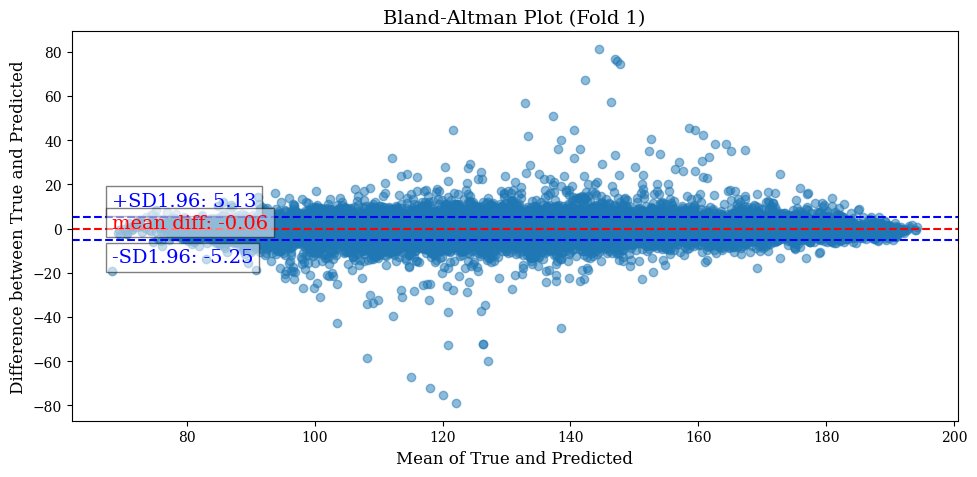

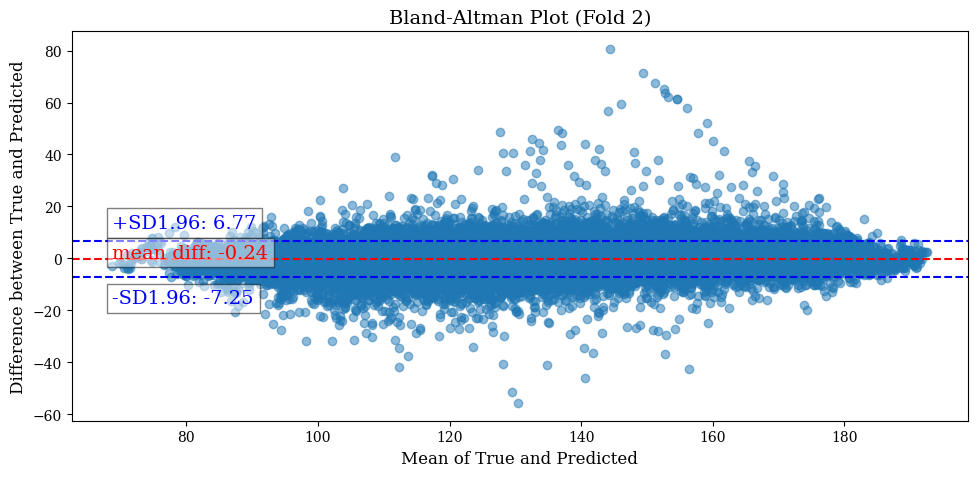

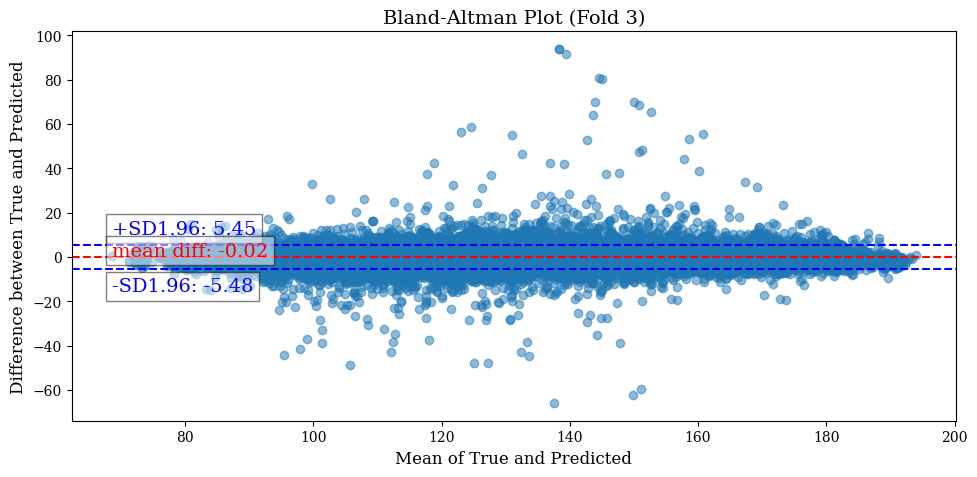

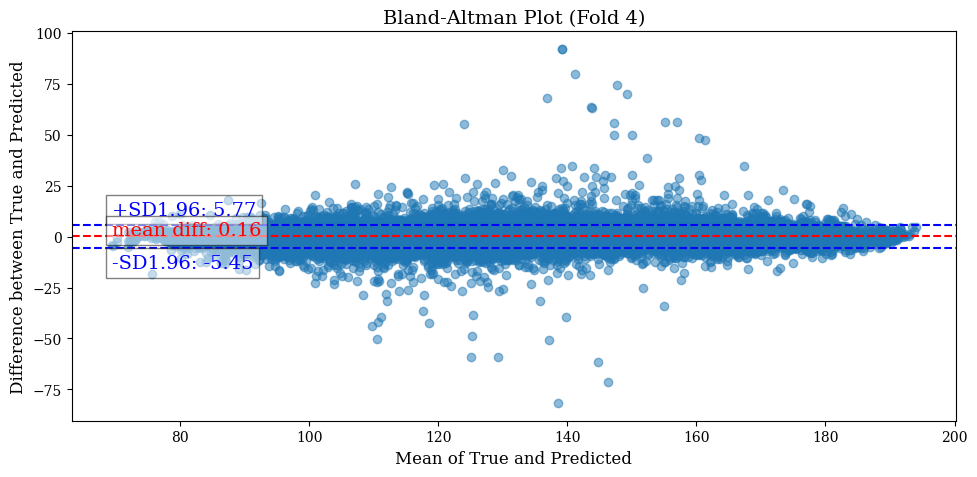

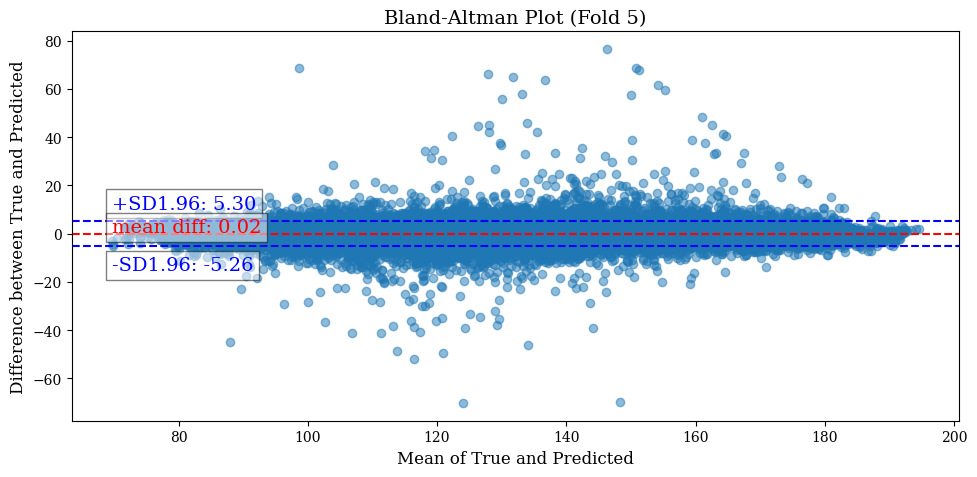

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


for i in range(len(all_true_values)):
    true_values = np.array(all_true_values[i])
    predictions = np.array(all_predictions[i])

    if true_values.shape != predictions.shape:
        print(f"Mismatch in shapes at fold {i+1}: true_values shape {true_values.shape}, predictions shape {predictions.shape}")

        predictions = predictions.flatten()
        all_predictions[i] = predictions

def bland_altman_plot(true_values, predictions, fold):
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    mean = np.mean([true_values, predictions], axis=0)
    diff = true_values - predictions
    md = np.mean(diff)
    sd = np.std(diff)

    plt.figure(figsize=(10, 5))
    plt.scatter(mean, diff, alpha=0.5)
    plt.axhline(md, color='red', linestyle='--')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.title(f'Bland-Altman Plot (Fold {fold})', fontsize=14)
    plt.xlabel('Mean of True and Predicted', fontsize=12)
    plt.ylabel('Difference between True and Predicted', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


    plt.text(np.min(mean), md + 1.96*sd + 5, f'+SD1.96: {md + 1.96*sd:.2f}', color='blue', bbox=dict(facecolor='white', alpha=0.5))
    plt.text(np.min(mean), md - 1.96*sd - 10, f'-SD1.96: {md - 1.96*sd:.2f}', color='blue', bbox=dict(facecolor='white', alpha=0.5))
    plt.text(np.min(mean), md + 0.5, f'mean diff: {md:.2f}', color='red', bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'Bland_Altman_Fold_{fold}.png', dpi=300)
    plt.show()


for i in range(k_folds):
    bland_altman_plot(all_true_values[i], all_predictions[i], i+1)

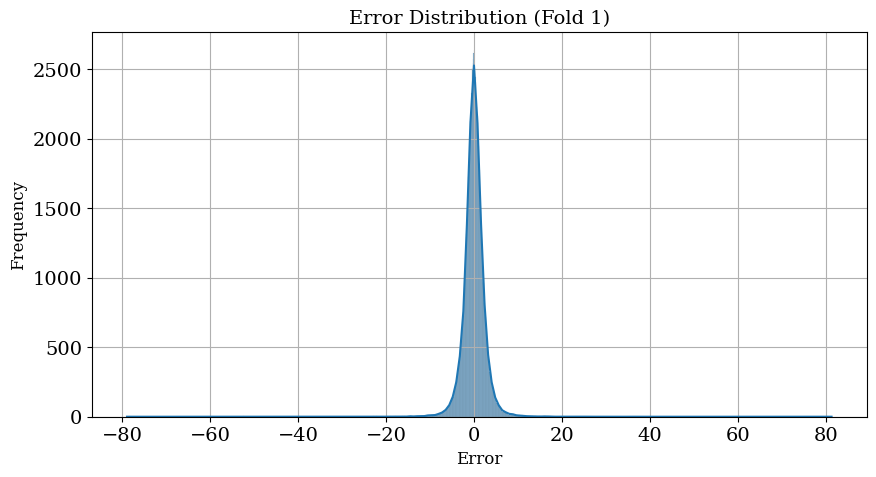

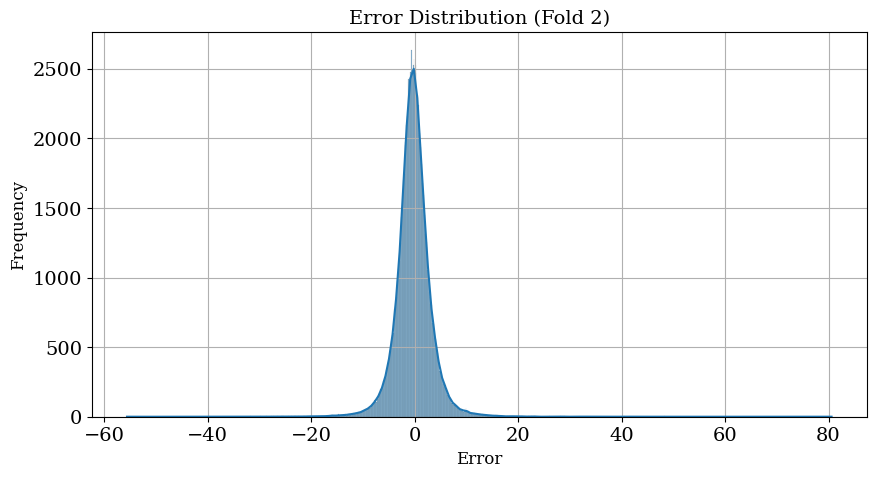

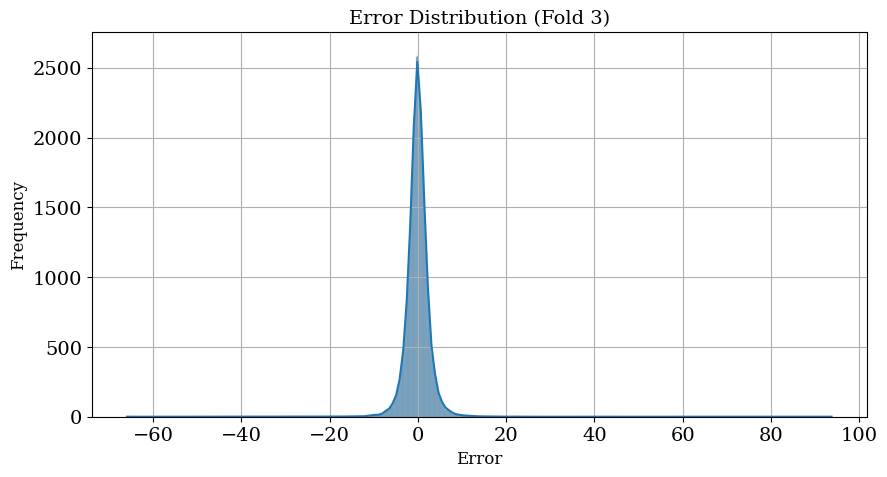

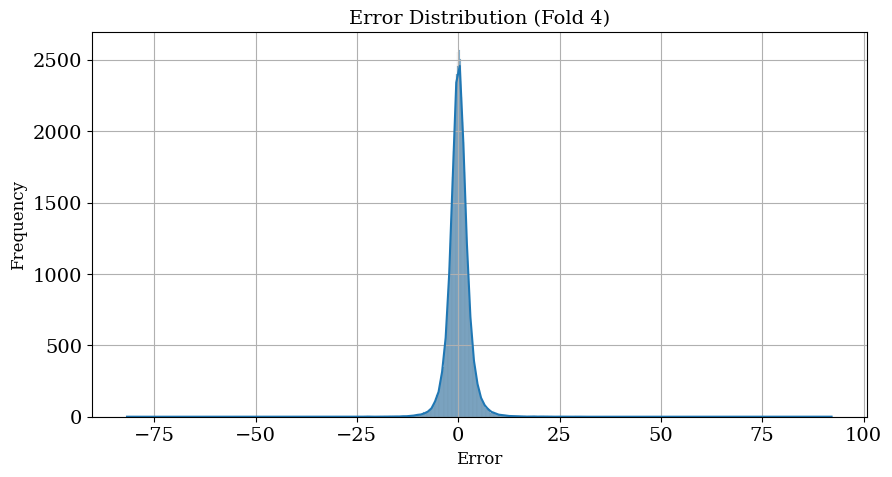

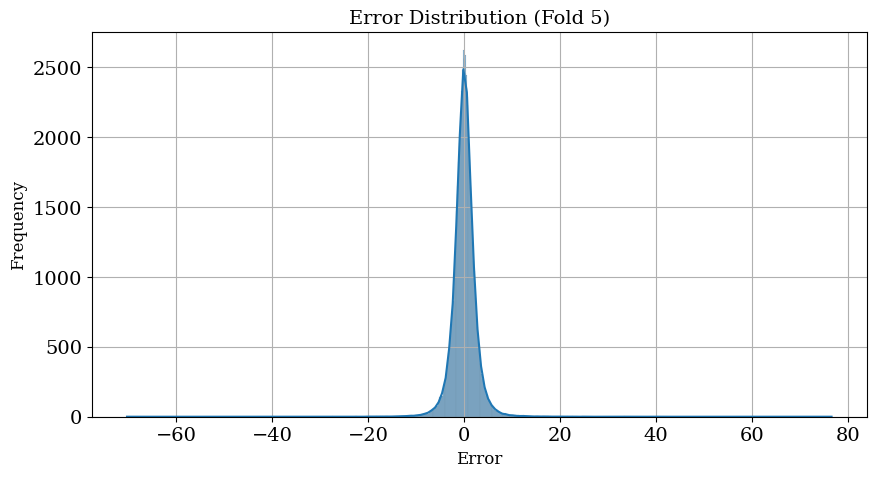

In [ ]:
import seaborn as sns
def plot_error_distribution(all_true_values, all_predictions, fold):
    true_values = np.concatenate(all_true_values)
    predictions = np.concatenate(all_predictions)
    errors = true_values - predictions

    plt.figure(figsize=(10, 5))
    sns.histplot(errors, kde=True)
    plt.title(f'Error Distribution (Fold {fold})', fontsize=14)
    plt.xlabel('Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.savefig(f'Error_Distribution_Fold_{fold}.png', dpi=300)
    plt.show()


for i in range(k_folds):
    plot_error_distribution([all_true_values[i]], [all_predictions[i]], i+1)


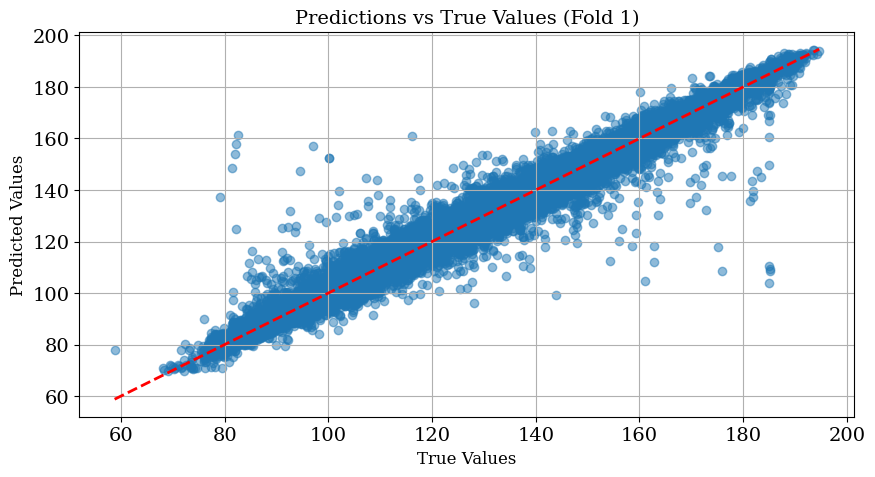

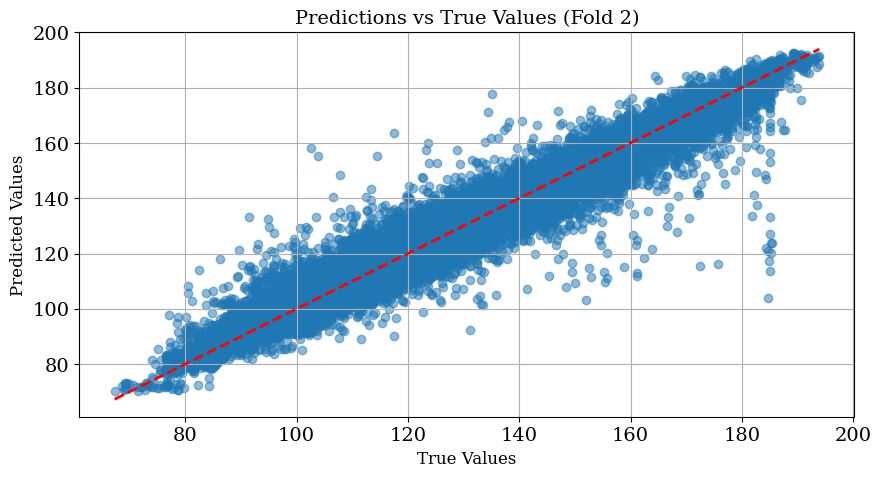

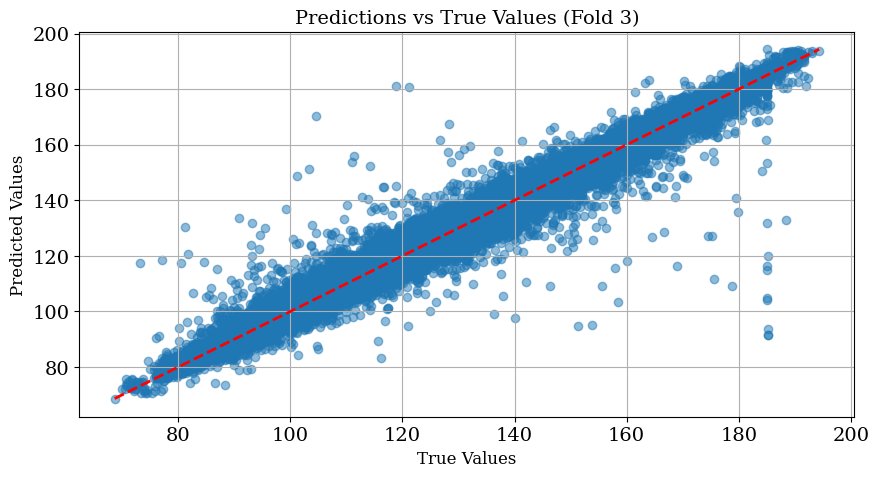

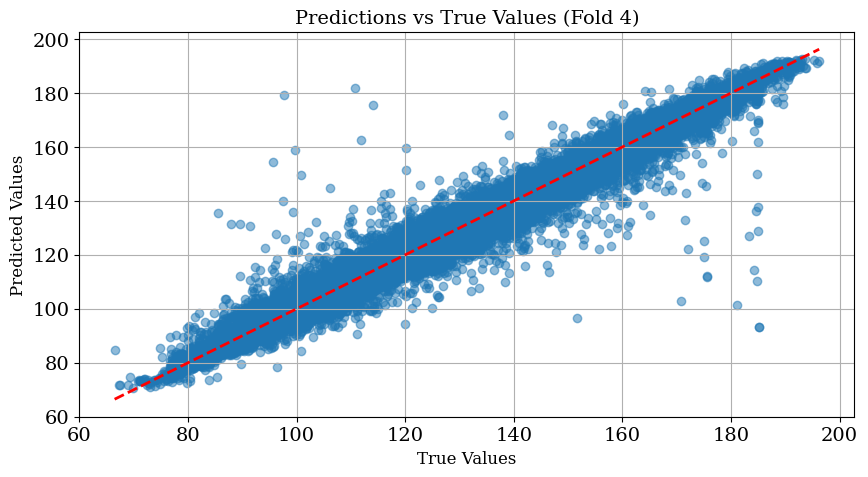

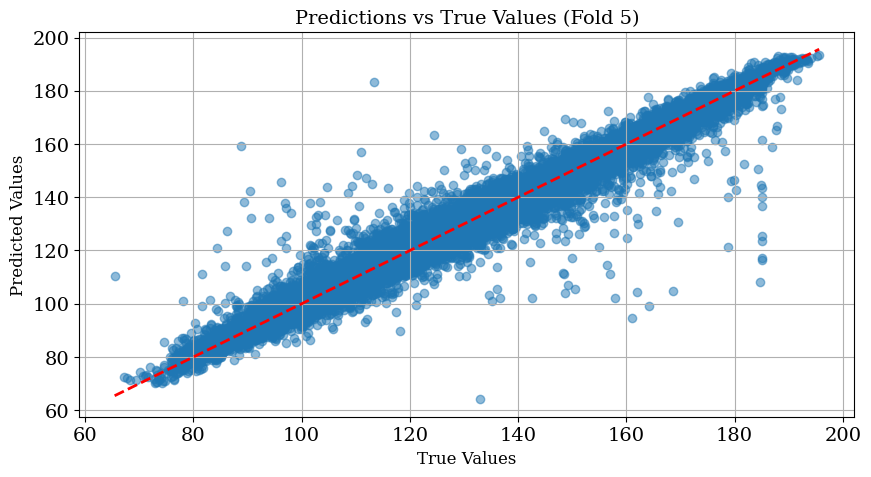

In [ ]:
def plot_predictions_vs_true(all_true_values, all_predictions, fold):
    true_values = np.concatenate(all_true_values)
    predictions = np.concatenate(all_predictions)

    plt.figure(figsize=(10, 5))
    plt.scatter(true_values, predictions, alpha=0.5)
    plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
    plt.title(f'Predictions vs True Values (Fold {fold})', fontsize=14)
    plt.xlabel('True Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.grid(True)
    plt.savefig(f'Predictions_vs_True_Fold_{fold}.png', dpi=300)
    plt.show()


for i in range(k_folds):
    plot_predictions_vs_true([all_true_values[i]], [all_predictions[i]], i+1)

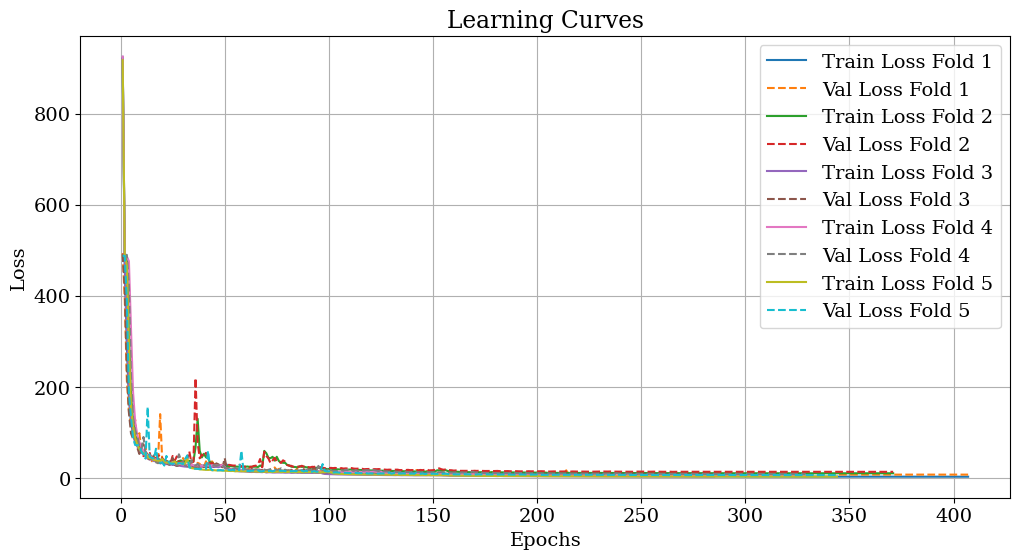

In [ ]:
def plot_learning_curves(all_train_losses, all_val_losses):
    plt.figure(figsize=(12, 6))

    for fold in range(k_folds):
        plt.plot(range(1, len(all_train_losses[fold]) + 1), all_train_losses[fold], label=f'Train Loss Fold {fold+1}')
        plt.plot(range(1, len(all_val_losses[fold]) + 1), all_val_losses[fold], label=f'Val Loss Fold {fold+1}', linestyle='--')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.savefig('Learning_Curves.png', dpi=300)
    plt.show()


plot_learning_curves(all_train_losses, all_val_losses)
